In [1]:
import sys
sys.path.insert(0, '/home/oscarwu/code/chemprop_developing')

import pickle as pkl
import numpy as np
import pandas as pd

In [2]:
# load an example
df_smi = pd.read_csv('esol.csv')
df_smi.iloc[[7]]

,smiles,logSolubility
7,CC#N,0.26


In [3]:
smiles = df_smi.iloc[[7]]['smiles'].values.tolist()

In [4]:
smiles

['CC#N']

In [5]:
from chemprop.features.utils import load_features, load_valid_atom_or_bond_features
from chemprop.models.mpn import mask_features_extra_batch, mask_features_extra

In [6]:
bond_features = [load_valid_atom_or_bond_features('esol_wb97xd_bond_RBF_features.pkl', smiles)[7]]

In [7]:
atom_descriptors = [load_valid_atom_or_bond_features('esol_wb97xd_atom_RBF_features.pkl', smiles)[7]]

In [8]:
mol_features = [load_features("esol_wb97xd_molecule_features.csv")[7].reshape(1, -1)]

In [9]:
# Example SHAP Analysis
# Imports
from chemprop.args import TrainArgs
from chemprop.models.model import MoleculeModel

import torch
from chemprop.utils import load_checkpoint, load_scalers
from chemprop.features import set_extra_bond_fdim

from rdkit import Chem
from chemprop.rdkit import make_mol

# Load TrainArgs and MoleculeModel
path = "/home/oscarwu/code/chemprop_developing/developing/shap_v1/data/model.pt"
state = torch.load(path, map_location=lambda storage, loc: storage)
train_args = TrainArgs()
train_args.from_dict(vars(state["args"]), skip_unsettable=True)
set_extra_bond_fdim(train_args.bond_features_size)
model = load_checkpoint(path)
scalers = load_scalers(path)

# Create a MoleculeModel Wrapper
class MoleculeModelWrapper:
    def __init__(self, model, train_args, scalers, smiles, shap, features_batch, 
                 atom_descriptors_batch, atom_features_batch, bond_descriptors_batch, bond_features_batch):
        self.model = model.eval()
        self.train_args = train_args
        self.target_scaler, self.mol_feature_scaler, _, _, _ = scalers
        self.smiles = smiles
        self.shap = shap
        if features_batch is not None:
            self.features_batch = [self.mol_feature_scaler.transform(feat) for feat in features_batch]
        else:
            self.features_batch = None      
        self.atom_descriptors_batch = atom_descriptors_batch
        self.atom_features_batch = atom_features_batch
        self.bond_descriptors_batch = bond_descriptors_batch
        self.bond_features_batch = bond_features_batch
        
        self.batch = None
        self.extra_keep_features_batch = None
        self.extra_atom_keep_descriptors_batch = None
        self.extra_bond_keep_descriptors_batch = None
        self.extra_atom_keep_features_batch = None
        self.extra_bond_keep_features_batch = None
        self.chemprop_atom_keep_features = None
        self.chemprop_bond_keep_features = None
        

    def __call__(self, feature_choices):
        if isinstance(feature_choices, np.ndarray):
            if len(feature_choices.shape) == 1:
                feature_choices = feature_choices.reshape(1, -1)
                
        result = []
        
        for feature_choice in feature_choices:
        
            self.batch = [[make_mol(s=smi, keep_h=True, add_h=True, keep_atom_map=True)] for smi in self.smiles]
            self.extra_keep_features_batch = [feature_choice[0:20]] # 20 extra molecular features
            self.extra_atom_keep_descriptors_batch = [feature_choice[20:33]] # 13 atom descriptors
            self.extra_bond_keep_descriptors_batch = None # 0 bond descriptors
            self.extra_atom_keep_features_batch = None # 0 atom features
            self.extra_bond_keep_features_batch = [feature_choice[33:37]] # 4 bond features
            self.chemprop_atom_keep_features = feature_choice[37:45] # 8 chemprop atom features
            self.chemprop_bond_keep_features = feature_choice[45:49] # 4 chemprop bond features
            
            # this is from forward in original MoleculeModel in model.py
            output = self.model(batch=self.batch, 
                                features_batch=self.features_batch, 
                                atom_descriptors_batch=self.atom_descriptors_batch, 
                                atom_features_batch=self.atom_features_batch, 
                                bond_descriptors_batch=self.bond_descriptors_batch, 
                                bond_features_batch=self.bond_features_batch, 
                                constraints_batch=None,
                                bond_types_batch=None,
                                shap=self.shap, 
                                extra_keep_features_batch=self.extra_keep_features_batch, 
                                extra_atom_keep_descriptors_batch=self.extra_atom_keep_descriptors_batch, 
                                extra_bond_keep_descriptors_batch=self.extra_bond_keep_descriptors_batch, 
                                extra_atom_keep_features_batch=self.extra_atom_keep_features_batch, 
                                extra_bond_keep_features_batch=self.extra_bond_keep_features_batch, 
                                chemprop_atom_keep_features=self.chemprop_atom_keep_features, 
                                chemprop_bond_keep_features=self.chemprop_bond_keep_features)
        
            # xform = self.target_scaler.inverse_transform(output.item()).item()
            # xform = np.array(xform, ndmin=2)
            # result.append(xform)
            result.append(output.item())
        
        return np.array(result).reshape(len(feature_choices), -1)
        

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "encoder.encoder.0.atom_descriptors_layer.weight".
Loading pretrained parameter "encoder.encoder.0.atom_descriptors_layer.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Loading pretrained parameter "readout.7.weight".
Loading pretrained parameter "readout.7.bias".


In [10]:
model_wrapper = MoleculeModelWrapper(model=model, 
                                     train_args=train_args, 
                                     scalers=scalers, 
                                     smiles=smiles, 
                                     shap=True, 
                                     features_batch=mol_features, 
                                     atom_descriptors_batch=atom_descriptors, 
                                     atom_features_batch=None, 
                                     bond_descriptors_batch=None, 
                                     bond_features_batch=bond_features)

In [11]:
# SHAP
import shap
from shap import PermutationExplainer
from copy import deepcopy

def binary_masker(binary_mask, x):
    masked_x = deepcopy(x)
    masked_x[binary_mask == 0] = 0
    return np.array([masked_x])

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [12]:
explainer = PermutationExplainer(model=model_wrapper, masker=binary_masker)

In [13]:
feature_choice = np.array([[1]*49])

In [14]:
model_wrapper(feature_choice)

array([[1.48271787]])

In [15]:
model_wrapper(feature_choice).item()

1.4827178716659546

In [16]:
explanation = explainer(feature_choice, max_evals=1000)
print(explanation)

.values =
array([[-0.05327574, -0.04715089,  0.02519653, -0.0070666 ,  0.03448988,
         0.03609382,  0.04536672,  0.03180809,  0.02394752,  0.01042053,
         0.04450883,  0.05889422,  0.05656175,  0.06267466,  0.06548277,
         0.06878731,  0.07066401,  0.02768922,  0.06042446, -0.02717628,
         0.02075078,  0.02282744,  0.01176239,  0.14443679,  0.10769511,
         0.01130493,  0.00106076,  0.05120225,  0.00074406,  0.03293782,
         0.01116467,  0.00220876,  0.0106838 , -0.07156681,  0.05407252,
         0.00377751,  0.02138989,  0.02814582,  0.02516038,  0.01194855,
         0.00644765,  0.00731717,  0.00148765,  0.        , -0.00100613,
        -0.01927474,  0.        ,  0.        ,  0.00418033]])

.base_values =
array([[0.3935177]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])


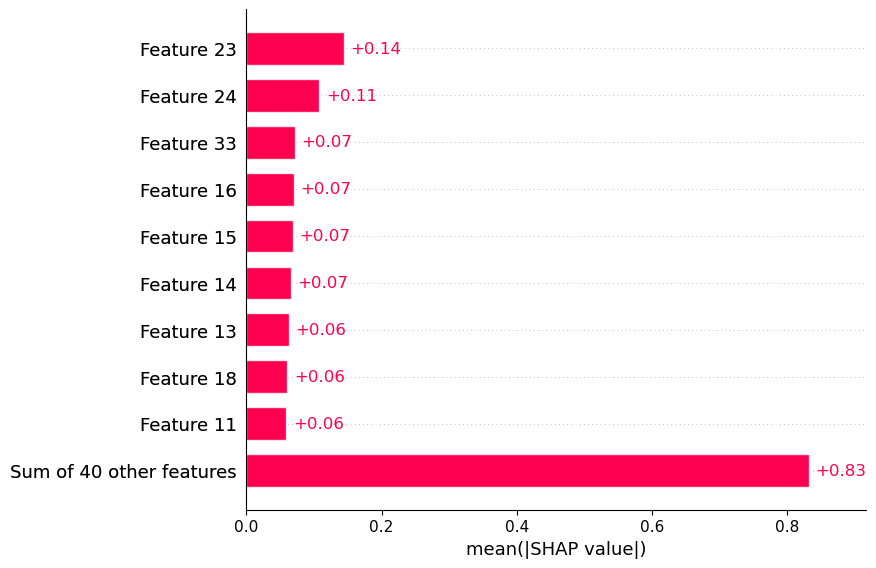

In [18]:
shap.plots.bar(explanation, max_display=10)

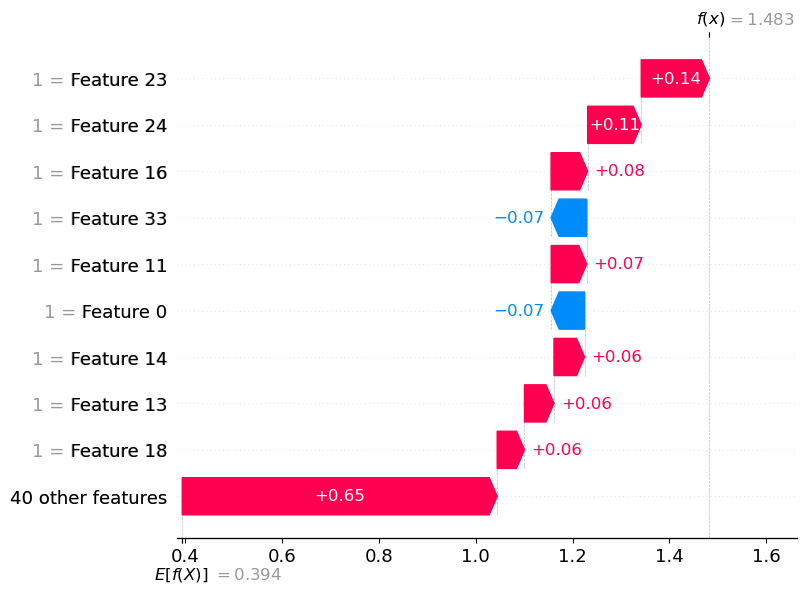

In [21]:
shap.plots.waterfall(explanation[0], max_display=10)

In [18]:
explanation = explainer(feature_choice, max_evals=1000)
print(explanation)

.values =
array([[-0.06892973, -0.04219402,  0.01247639,  0.01417628,  0.0302674 ,
         0.0323979 ,  0.04095022,  0.04198957,  0.03473011,  0.01241598,
         0.04765238,  0.07345891,  0.05356852,  0.0609745 ,  0.06315273,
         0.05261384,  0.0755693 ,  0.03213342,  0.05635708, -0.02810182,
         0.01919153,  0.02394693,  0.01123151,  0.14096223,  0.11067328,
         0.01121768,  0.00230277,  0.05175726,  0.00071212,  0.03083672,
         0.01212998,  0.00127681,  0.01071314, -0.07369711,  0.0486412 ,
         0.00958824,  0.02470028,  0.02658017,  0.02449134,  0.00579907,
         0.01130554,  0.00398565, -0.00155986,  0.        , -0.00060258,
        -0.01478248,  0.        ,  0.        ,  0.00213979]])

.base_values =
array([[0.3935177]])

.data =
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])


In [29]:
explanation.values = np.array([[-0.00482263, -0.00937565, -0.00961549, -0.00658987,  0.00305359,
         0.00792672, -0.00340259, -0.00797053,  0.0013253 ,  0.00644273,
         0.00014257, -0.00166819,  0.00915524,  0.00803045,  0.01252571,
         0.01448961,  0.01223905,  0.01350322, -0.0216333 , -0.0072697 ,
        -0.02799503, -0.02318391, -0.04374482, -0.11068841, -0.06013031,
        -0.01327596, -0.0179021 , -0.06190701, -0.05859499,  0.06551229,
         0.0131969 , -0.01414199,  0.01053044, -0.02227289, -0.01675863,
        -0.05448138,  0.00544552,  0.01089421, -0.01380961,  0.01999582,
         0.01835815,  0.00967331,  0.01576503, -0.01339447, -0.00915751,
        -0.01211627, -0.01892256, -0.00380637, -0.00521774]])

In [30]:
explanation.base_values = np.array([[0.41036616]])

In [37]:
mol_feature_names = ['HOMO-3/LUMO', 'HOMO-3/LUMO+1', 'HOMO-3/LUMO+2', 'HOMO-3/LUMO+3',
       'HOMO-2/LUMO', 'HOMO-2/LUMO+1', 'HOMO-2/LUMO+2', 'HOMO-2/LUMO+3',
       'HOMO-1/LUMO', 'HOMO-1/LUMO+1', 'HOMO-1/LUMO+2', 'HOMO-1/LUMO+3',
       'HOMO/LUMO', 'HOMO/LUMO+1', 'HOMO/LUMO+2', 'HOMO/LUMO+3', 'IP', 'EA',
       'mulliken_dipole_tot', 'mulliken_quadrupoles']

atom_descriptor_names = [
    "npa_charge",
    "npa_charge_plus",
    "npa_charge_minus",
    "npa_parr_neu",
    "npa_parr_elec",
    "shielding_constants",
    "1s_val_occ",
    "2s_val_occ",
    "2p_val_occ",
    "3s_val_occ",
    "3p_val_occ",
    "4s_val_occ",
    "4p_val_occ",
]

bond_feature_names = [
    "bond_index_matrix",
    "bond_length_matrix",
    "mulliken_condensed_charge_matrix",
    "natural_ionicity",
]

In [40]:
explanation.feature_names = [
'mol-HOMO-3/LUMO', 'mol-HOMO-3/LUMO+1', 'mol-HOMO-3/LUMO+2', 'mol-HOMO-3/LUMO+3',
       'mol-HOMO-2/LUMO', 'mol-HOMO-2/LUMO+1', 'mol-HOMO-2/LUMO+2', 'mol-HOMO-2/LUMO+3',
       'mol-HOMO-1/LUMO', 'mol-HOMO-1/LUMO+1', 'mol-HOMO-1/LUMO+2', 'mol-HOMO-1/LUMO+3',
       'mol-HOMO/LUMO', 'mol-HOMO/LUMO+1', 'mol-HOMO/LUMO+2', 'mol-HOMO/LUMO+3', 'mol-IP', 'mol-EA',
       'mol-mulliken_dipole_tot', 'mol-mulliken_quadrupoles', "atom-npa_charge",
    "atom-npa_charge_plus",
    "atom-npa_charge_minus",
    "atom-npa_parr_neu",
    "atom-npa_parr_elec",
    "atom-shielding_constants",
    "atom-1s_val_occ",
    "atom-2s_val_occ",
    "atom-2p_val_occ",
    "atom-3s_val_occ",
    "atom-3p_val_occ",
    "atom-4s_val_occ",
    "atom-4p_val_occ",
    "bond-bond_index_matrix",
    "bond-bond_length_matrix",
    "bond-mulliken_condensed_charge_matrix",
    "bond-natural_ionicity",
    "chemprop-atom-atomic_num",
    "chemprop-atom-degree",
    "chemprop-atom-formal_charge",
    "chemprop-atom-chiral_tag",
    "chemprop-atom-num_Hs",
    "chemprop-atom-hybridization",
    "chemprop-atom-GetIsAromatic",
    "chemprop-atom-GetMass",
    "chemprop-bond-BondType",
    "chemprop-bond-GetIsConjugated",
    "chemprop-bond-IsInRing",
    "chemprop-bond-GetStereo",
]

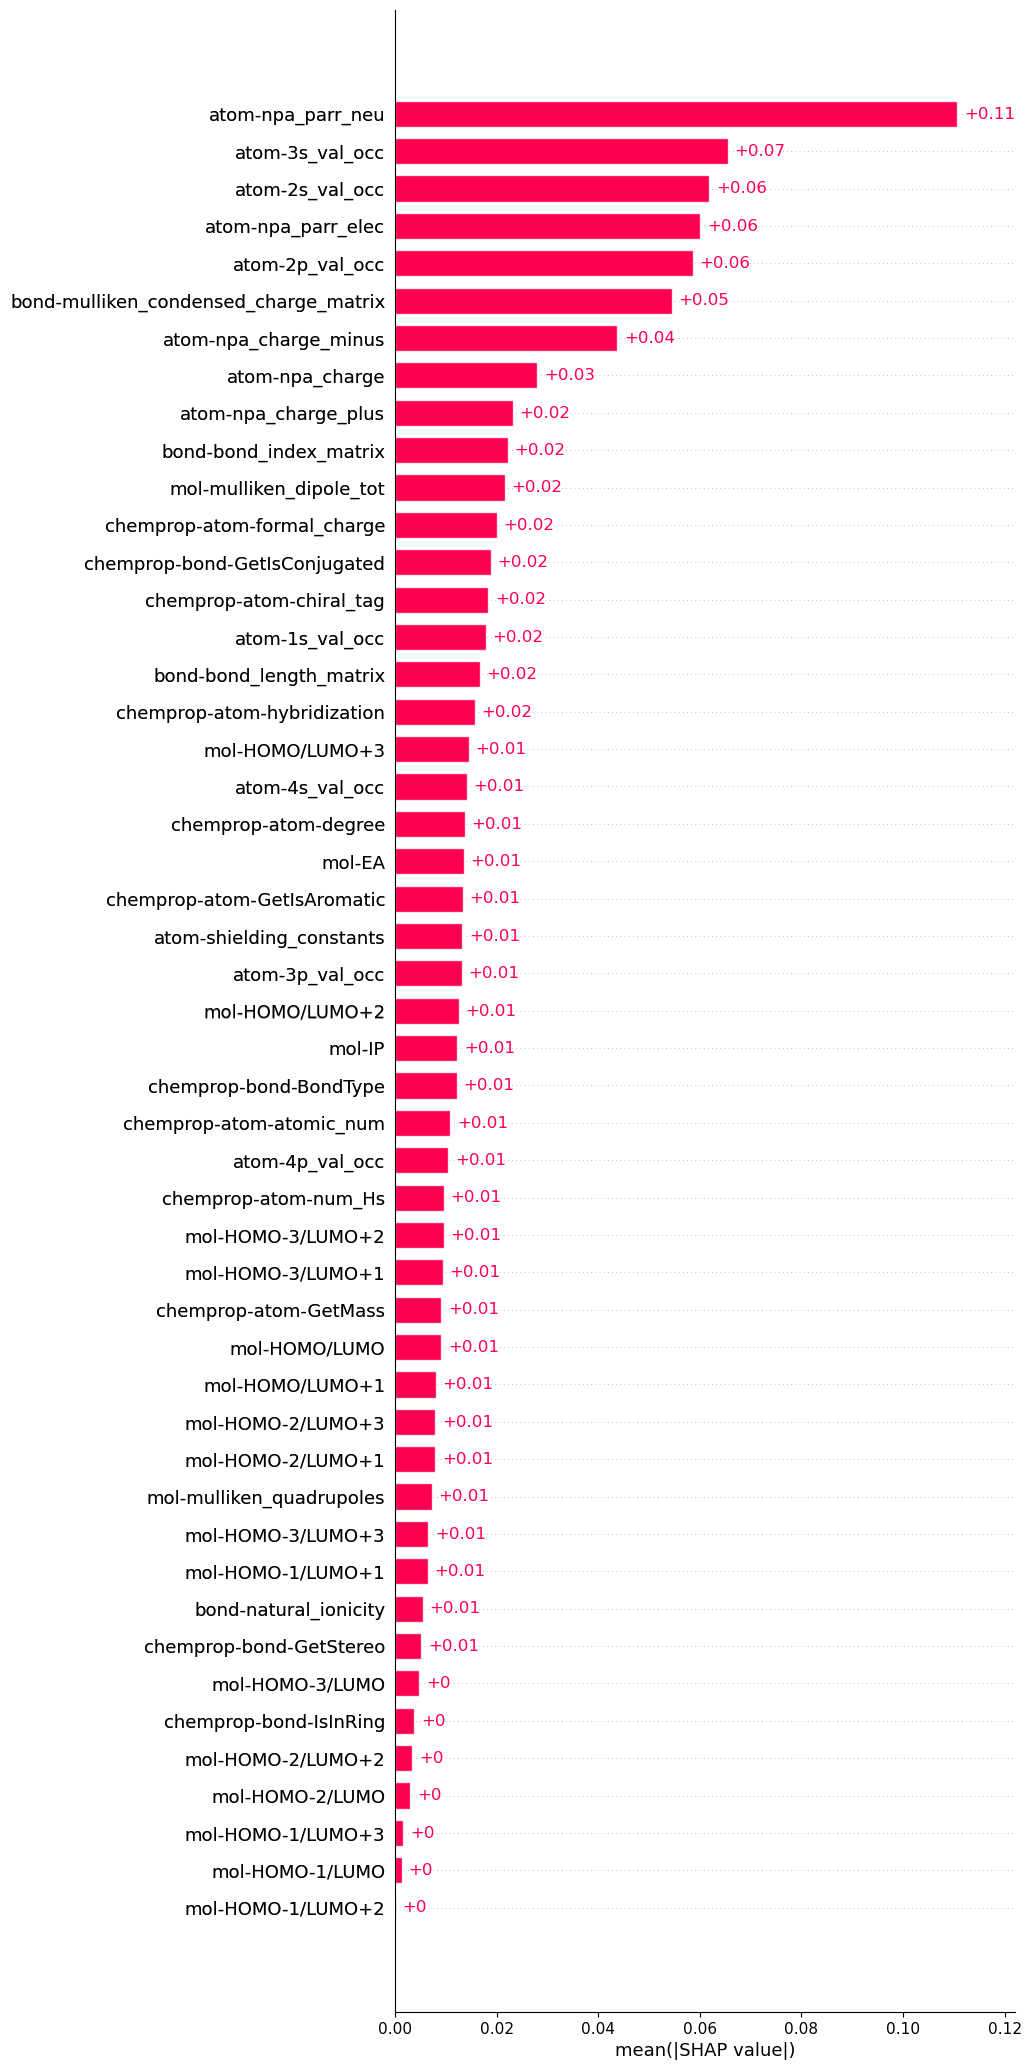

In [41]:
shap.plots.bar(explanation, max_display=50)

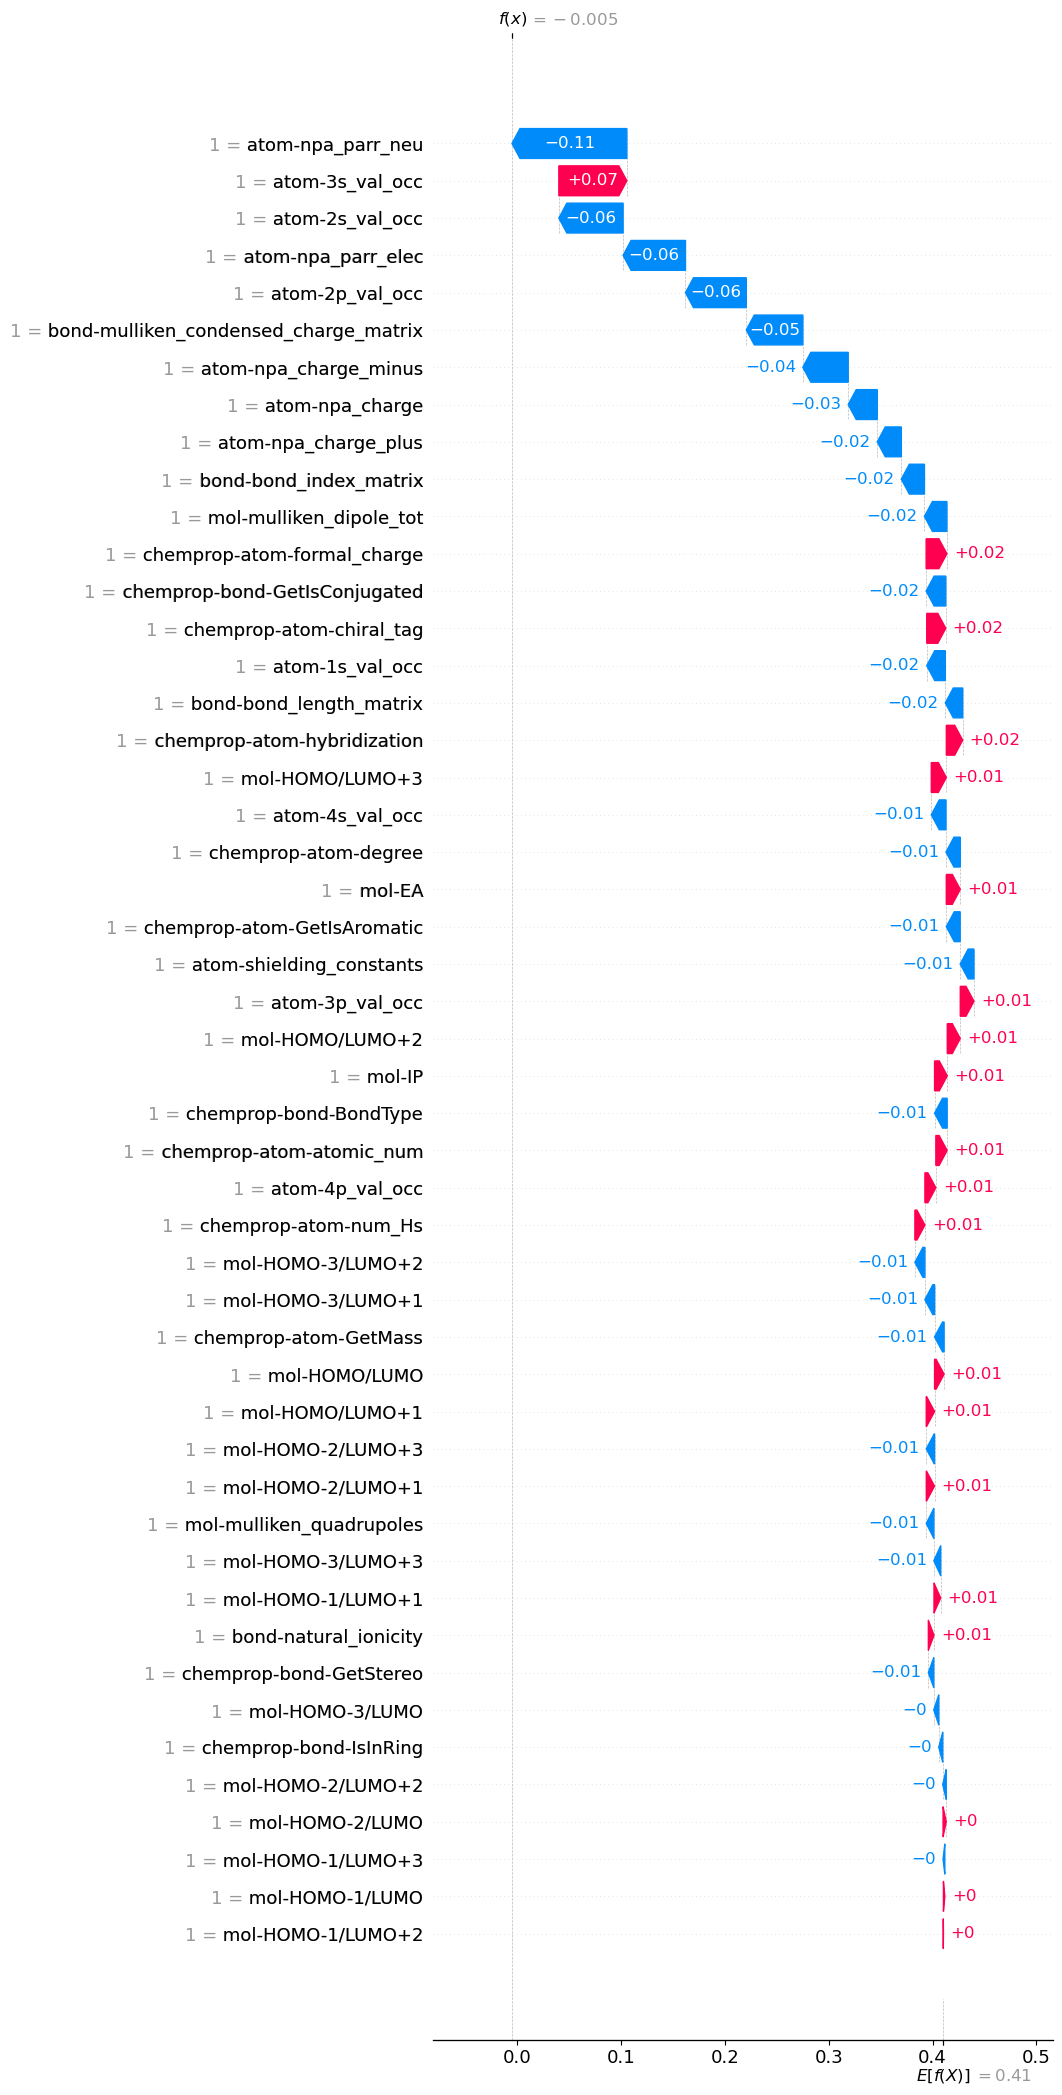

In [42]:
shap.plots.waterfall(explanation[0], max_display=50)

In [44]:
# Define the slices for each feature type
extra_keep_features_batch = explanation.values[:, 0:20] # 20 extra molecular features
extra_atom_keep_descriptors_batch = explanation.values[:, 20:33] # 13 atom descriptors
extra_bond_keep_features_batch = explanation.values[:, 33:37] # 4 bond features
chemprop_atom_keep_features = explanation.values[:, 37:45] # 8 chemprop atom features
chemprop_bond_keep_features = explanation.values[:, 45:49] # 4 chemprop bond features

# Sum each feature type
sum_extra_keep_features = np.sum(extra_keep_features_batch)
sum_extra_atom_keep_descriptors = np.sum(extra_atom_keep_descriptors_batch)
sum_extra_bond_keep_features = np.sum(extra_bond_keep_features_batch)
sum_chemprop_atom_keep_features = np.sum(chemprop_atom_keep_features)
sum_chemprop_bond_keep_features = np.sum(chemprop_bond_keep_features)

# Print the results
print("Sum of extra molecular features:", sum_extra_keep_features)
print("Sum of atom descriptors:", sum_extra_atom_keep_descriptors)
print("Sum of bond features:", sum_extra_bond_keep_features)
print("Sum of chemprop atom features:", sum_chemprop_atom_keep_features)
print("Sum of chemprop bond features:", sum_chemprop_bond_keep_features)

Sum of extra molecular features: 0.01648624000000001
Sum of atom descriptors: -0.3423249
Sum of bond features: -0.08806738000000001
Sum of chemprop atom features: 0.03832493
Sum of chemprop bond features: -0.040062940000000005


In [45]:
extra_keep_features_batch

array([[-0.00482263, -0.00937565, -0.00961549, -0.00658987,  0.00305359,
         0.00792672, -0.00340259, -0.00797053,  0.0013253 ,  0.00644273,
         0.00014257, -0.00166819,  0.00915524,  0.00803045,  0.01252571,
         0.01448961,  0.01223905,  0.01350322, -0.0216333 , -0.0072697 ]])

In [46]:
explanation.values = np.array([[ 0.01648624000000001, -0.3423249, -0.08806738000000001, 0.03832493, -0.040062940000000005]])

In [47]:
explanation.feature_names = ["sum_extra_keep_features", "sum_extra_atom_keep_descriptors", "sum_extra_bond_keep_features", "sum_chemprop_atom_keep_features", "sum_chemprop_bond_keep_features"]

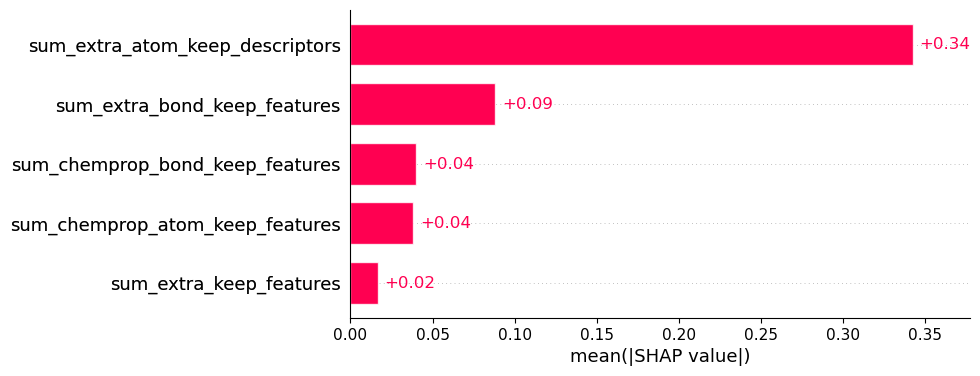

In [48]:
shap.plots.bar(explanation, max_display=5)

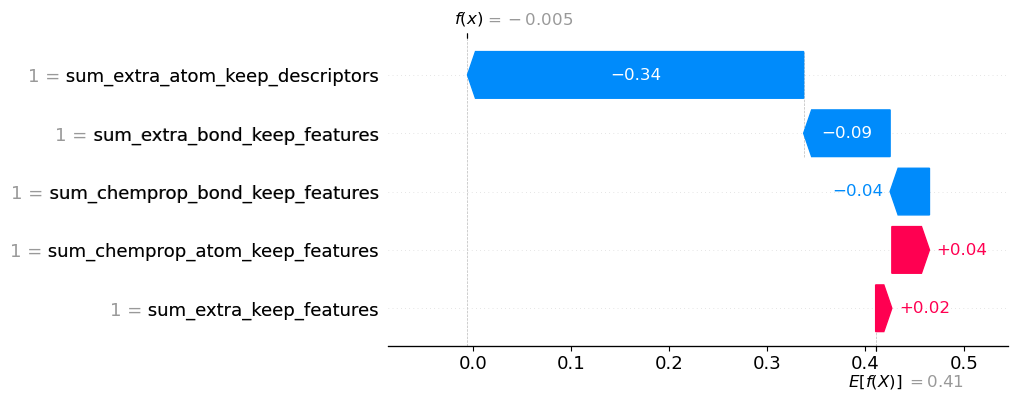

In [49]:
shap.plots.waterfall(explanation[0], max_display=5)